Fixing from notes. See page 85. redoing order of summation. 

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import itertools
from mpl_toolkits.mplot3d import Axes3D
from RayTraceFun_forDetTest import *
from PossibleFunctionsDetTest import *
from BackgroundDetTest import *
from random import uniform
import random
import matplotlib
import pickle
import time #to save figs automatically time.strftime("%Y_%m_%d_%s")
#%matplotlib auto

In [2]:
def OFDM(Rays,y): #output from detector with mirror at Y
    Rayf = []
    for i in range(len(Rays)):
        Paths = [TTTTioM,RRRRioM,TTRRioM,RTTRioM,RTRTioM,TRRTioM,RRTTioM,TRTRioM]
        Ri = Rays[i]
        for j in range(8):
            origin = (0,y,0)
            out = Paths[j](Ri,p1,p2,p3,p4,origin)
            if out is not None:
                Rayf.append(out)
    return Rayf

def checkoutraysM(Rays,center,r): #RAYS THAT HIT DETECTOR
    GRays = []
    for i in range(len(Rays)):
        det = PLINTzS(80.,Rays[i][2],Rays[i][3])
        Rays[i][2] = det
        Rays[i][0] = Rays[i][0] + np.pi #reflection changes polarization
        d = ((det[0]-center[0])**2) + ((det[1]-center[1])**2) #if it is within detector
        if d <= r**2: 
            GRays.append(Rays[i])
    return GRays

def RunRaysMi(Rays,y): #just give number of rays to be run through this FTS at a specific y!
    Rayf = OFDM(Rays,y)
    G= checkoutraysM(Rayf,[160.375,-113],7.9375) # GOOD RAYS ONLY 
    Gtestsorted = sortgrid(G)
    Regions = regionalize(Gtestsorted)
    return Gtestsorted,Regions


def makeraysiFIXED(n,r):
    sourcepointorigin = [-160.375,-113.,-80.0] #LOCAL 
    sourcethet = [0.,0.,0.] #SHOT STRAIGHT UP
    sourcepoints = specsource(r,sourcepointorigin,sourcethet,n) # SOURCE
    Rays = FSRay(n,sourcepoints, sourcethet,origin10)
    for i in range(n):
        Rays[i][2] = sourcepointorigin
        v1x,v1y,v1z = transformLG(0.,0.,1,originG,sourcethet)
        v2 = sepop(v1x,v1y,v1z)
        Rays[i][3]=v2
    return Rays

def SumjRegionsMi_TestG(Rays,y): #ALSO INCORPORATES PHASE
    OutRays,regions=RunRaysMi(Rays,y)
    Regions = list(regions)
    jx,jy = gridlines(7.9375,[160.375,-113],200)
    LamdAll = np.linspace(1, 10,300) #possible wavelengths (30-300 Ghz), steps of 1Ghz
    DetTot = []
    for j in range(len(regions)):
        ExTot = []
        EyTot = []
        for i in range(len(Regions[j])): #All rays in region j
            #ExTot = []
            #EyTot = []
            if i != 0 and i != 1:
                JRegion = Regions[j]
                o,p = JRegion[0],JRegion[1] # jx and jy defining the jth region
                Raym = OutRays[JRegion[i]] #ith ray in the jth region
                if o != len(jx)-1 and p !=len(jy)-1:
                    #w = 1
                    w = gaussian3d(Raym[2][0],Raym[2][1],.4,(jx[o]+jx[o+1])/2,(jy[p]+jy[p+1])/2)
                else: 
                    w = 0 #(skipping gaussian)
                #Raym[1] is intensity!!! #split into x and y components of AMPLITUDE field
                #w = 1
                I = Raym[1]
                thet = Raym[0]
                Ex1,Ey1 = w*np.sqrt(I)*np.cos(thet),w*np.sqrt(I)*np.sin(thet) #multiplied by gaussian
                #only one frequency 
                Lamd = 3.3
                phase = np.exp(1j*(Raym[4]%Lamd)*2*np.pi/Lamd)
                #phase = np.exp(2*np.pi*1j*Raym[4]/Lamd)
                Ex = Ex1*phase
                Ey = Ey1*phase
                ExTot.append(Ex)
                EyTot.append(Ey)
        Ij = (np.sum(ExTot)*np.sum(ExTot).conjugate()) + (np.sum(EyTot)*np.sum(EyTot).conjugate())
        DetTot.append(Ij.real)
    return np.sum(DetTot)

def RunFTSLimiStraightTest(n,r,div,Lim):
    Power = []
    Delay = []
    Rays = makeraysiFIXED(n,r)
    for y in np.linspace(-int(Lim),int(Lim),div):
        I = SumjRegionsMi_TestG(Rays,y)
        Power.append(I)
        Delay.append(y)
    return Power,Delay 

#is normalized now
def Airygaussian3dNORM(x,y,sig,mux,muy): #assuming is symmetric, making peak = 1
   # A = 1
    A = (1/((sig**3)*(2*np.pi)**(3/2)))
    return A*np.exp(-(((x-mux)**2)/(2*sig**2) + ((y-muy)**2)/(2*sig**2)))

def Airygaussian3d(x,y,sig,mux,muy): #assuming is symmetric, making peak = 1
    A = 1
    #A = (1/((sig**3)*(2*np.pi)**(3/2)))
    return A*np.exp(-(((x-mux)**2)/(2*sig**2) + ((y-muy)**2)/(2*sig**2)))

#given LAST ray and its wavelength, return sig, mux and muy to then be used in gaussian  
#see pg 79 for more details(approx of airy func)
def MakeGaussian(Ray,Lamd):
    mux,muy = Ray[2][0],Ray[2][1] #center of gaussian is intersection point
    width = 3.0988*Lamd
    sig = width/3
    return sig,mux,muy

#given the two positions of the last rays and wavelength, returns percentage of overlap (out of 1)
def gaussoverlap(Ray1,Ray2,Lamd):
    sig1,mux1,muy1 = MakeGaussian(Ray1,Lamd)
    sig2,mux2,muy2 = MakeGaussian(Ray2,Lamd)
    p1 = [mux1,muy1,80.] #points in 3d in GLOBAL coordinates
    p2 = [mux2,muy2,80.]
    MDValue = dist(p1,p2)
    MD = [0,.25,.5,.75,1,1.1,1.2,1.3,1.5,1.7,1.9,2.1,2.3,2.6,2.9,3.4,3.7,3.9] #mean difference
    GP = [1,.9,.8,.7,.62,.6,.55,.5,.45,.4,.35,.3,.25,.2,.15,.1,.07,.05] #Gaussian Percent
    idx = (np.abs(MD-MDValue)).argmin() #index number in array for closest value
    return GP[idx]

#find CENTER of each pixel now as [x,y]
def MakePixels(jx,jy):
    pix = []
    for o in range(len(jx)-1):
        for p in range(len(jy)-1):
            r = 7.9375
            xpix,ypix= (jx[o]+jx[o+1])/2,(jy[p]+jy[p+1])/2
            d = np.sqrt((xpix-160.375)**2 + ((ypix-(-113))**2))
            if d <= r: 
                pix.append([xpix,ypix])
    return pix

In [13]:
def RunOneRay(Lamd,Nsize): 
    n = 1
    r = 0
    Rays = makeraysiFIXED(n,r) 
    jx,jy = gridlines(7.9375,[160.375,-113],200) #these are now the PIXELS
    Pix = MakePixels(jx,jy) #center of each pixel
    Ij = []
    Delay = []
    for y in np.linspace(-18,18,int(Nsize)):
        PTot=0
        OutRays,regions=RunRaysMi(Rays,y) #eight each
        #Overlap = gaussoverlap(OutRays[0],OutRays[5],3.3) #two paths that hit two different spots 
        for j in range(len(Pix)): #per PIXEL
            Ex4i = 0 #adding PER PIXEL from parts of RAYS in this PIXEL
            Ey4i = 0 #THIS IS WHERE THEY WILL INTERFERE
            for i in range(len(OutRays)): #per ray IN THIS PIXEL
                I = OutRays[i][1]
                thet = OutRays[i][0]
                phase = np.exp(1j*(OutRays[i][4]*2*np.pi/Lamd)) #factor of 2??
                Ex1 = np.sqrt(I)*np.cos(thet)
                Ey1 = np.sqrt(I)*np.sin(thet)
                Ex = Ex1*phase
                Ey = Ey1*phase
                #doing summation over entire detector
                sig,mux,muy = MakeGaussian(OutRays[i],Lamd)
                Gr = Airygaussian3dNORM(Pix[j][0],Pix[j][1],sig,mux,muy)
                Ex4i = Ex4i + Gr*Ex
                Ey4i = Ey4i + Gr*Ey
            PTot = PTot + (Ex4i*Ex4i.conjugate()).real + (Ey4i*Ey4i.conjugate()).real
        Delay.append(y*0.95630475596*4)
        Ij.append(PTot)
    return Delay,Ij
#Delay,Ij = RunOneRay()        
#pl.plot(Delay,Ij) #treating detector like one pixel
#pl.tick_params(colors = 'white')
#pl.title('No Overlap\n$\lambda$='+str(Lamd),color = 'white')
#pl.xlabel('Path Difference (mm)', color = 'white')
#pl.show() 

print('Done')

Done


In [28]:
Lamd = 1.1
Nsize = 512
Freq = float(300/Lamd)
Delay,Ij = RunOneRay(Lamd,Nsize)

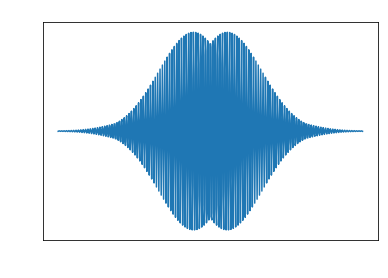

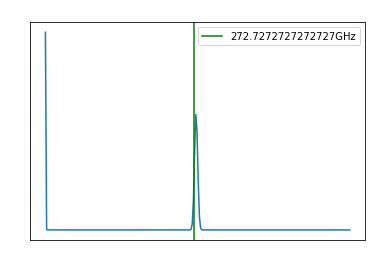

Done!


In [29]:
#f,u = spectrum(Ij,Nsize)
d1 = Ij
D = np.hanning(int(np.shape(d1)[0]))*d1
S = np.fft.rfft(D)
S = S[1:]
u = np.abs(S)
xtot = 36*0.95630475596*4 #total length of the scan
df = 1/xtot
f = df*np.arange(1+Nsize/2)

pl.plot(Delay,Ij) #treating detector like one pixel
pl.tick_params(colors = 'white')
pl.title('$\lambda$='+str(Lamd),color = 'white')
pl.xlabel('Path Difference (mm)', color = 'white')
pl.show() 
pl.plot(300*f[1:],u)
pl.title('FFT of above',color = 'white')
pl.xlabel('GHz', color = 'white')
pl.tick_params(colors = 'white')
#pl.xlim(0,500)
pl.axvline(x =float(Freq), color = 'green', label = str(Freq)+'GHz')

pl.legend()
pl.show()

print('Done!')

In [3]:
def checkpathdif(Lamd,Nsize):
    n = 1
    r = 0
    Rays = makeraysiFIXED(n,r) 
    jx,jy = gridlines(7.9375,[160.375,-113],200) #these are now the PIXELS
    Pix = MakePixels(jx,jy) #center of each pixel
    Yposition = []
    PathDifference = []
    for y in np.linspace(-18,18,int(Nsize)):
        PTot=0
        OutRays,regions=RunRaysMi(Rays,y) #eight each
        D = np.abs(float(OutRays[0][4])-float(OutRays[5][4]))
        Yposition.append(y)
        PathDifference.append(D)
    return Yposition,PathDifference
        
    

In [4]:
Y11,D11 = checkpathdif(1.1,256)
#Y22,D22 =checkpathdif(2.2)
#Y33,D33 = checkpathdif(3.3)
#calculating geometric by myself
def pathdif(y):
    Dfix = np.sqrt((128)**2 + 32.075**2)
    Dnew = np.sqrt((128+y)**2 + 32.075**2)
    dd = 4*np.abs(Dfix-Dnew)
    return dd

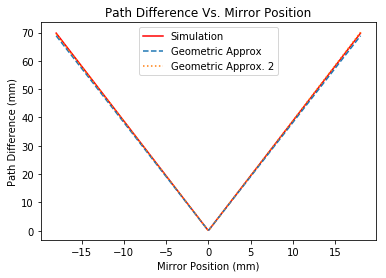

In [6]:
pl.plot(Y11,D11, color = 'red', label ='Simulation')
#pl.plot(Y22,D22, color = 'orange', label ='Simulation: $\lambda$=2.2mm')
#pl.plot(Y33,D33,color = 'blue', label ='Simulation: $\lambda$=3.3mm')
pl.title('Path Difference Vs. Mirror Position', color = 'black')
pl.xlabel('Mirror Position (mm)', color = 'black')
pl.ylabel('Path Difference (mm)', color = 'black')
YGeom = np.linspace(-18,18,256)
dd = np.abs(YGeom*0.95630475596*4)
pl.plot(YGeom,dd, linestyle = '--', label = 'Geometric Approx')
pl.plot(YGeom,pathdif(YGeom), linestyle = ':',label = 'Geometric Approx. 2')
pl.tick_params(colors = 'black')
pl.legend()
pl.savefig('pathdiff')
pl.show()